In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict as dd
import cv2
from skimage import exposure, color, io
from skimage.feature import hog
from scipy.fftpack import dct
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from collections import Counter

In [2]:
directories = glob.glob('../data/*')
directories.remove('../data/README')

image_files = {}

for dir in directories:
    if not image_files.get(dir.split('/')[-1]):
        image_files[dir.split('/')[-1]] = list()
    image_files[dir.split('/')[-1]] += glob.glob(dir + '/*')

In [3]:
data = np.zeros((40, 10, 112, 92))
target = []

for i, label in enumerate(image_files):
    for image_num in range(10):
        data[i, image_num] = color.rgb2gray(
            io.imread(image_files[label][image_num])
        )
        target.append(label)

In [4]:
class KNeighborsClassifier:
    
    def __init__(self, feature_to_use='hist', slice_fft=20, slice_dct=20, image_scale=4, gradient_param=8, n_neighbors=4):
        self.feature_to_use = feature_to_use
        self.slice_fft = slice_fft
        self.slice_dct = slice_dct
        self.image_scale = image_scale
        self.gradient_param = gradient_param
        self.n_neighbors = n_neighbors

    def preprocess_one_image(self, image):
        if self.feature_to_use == 'hist':
            return exposure.histogram(image)[0]
        if self.feature_to_use == 'fft':
            fft2 = np.fft.fft2(image)
            fft2 = fft2[:self.slice_fft, :self.slice_fft]
            return np.real(fft2).reshape(-1)
        if self.feature_to_use == 'dct':
            dct_ = dct(image.T).T
            dct_ = dct(dct_)
            return dct_[:self.slice_dct, :self.slice_dct].reshape(-1)
        if self.feature_to_use == 'scale':
            return cv2.resize(
                image, 
                (int(image.shape[0] / self.image_scale), int(image.shape[1] / self.image_scale))
            ).reshape(-1)
        else:
            return hog(
                image, 
                orientations=8, 
                pixels_per_cell=(self.gradient_param, self.gradient_param), 
                cells_per_block=(1, 1)
            )
    
    def get_class(self, image):
        processed = self.preprocess_one_image(image)
        euclid_distances = np.linalg.norm(processed - self.processed_data, axis=1)
        min_sum = float('inf')
        min_idx = -1
        step = int(len(euclid_distances) / 40)
        for i in range(0, len(euclid_distances), step):
            i_min, i_max = i, i + step
            sorted_distances = list(sorted(euclid_distances[i_min:i_max]))
            current_sum = sum(sorted_distances[:self.n_neighbors])
            if current_sum < min_sum:
                min_idx = i
                min_sum = current_sum
        return self.target[min_idx]
    
    def fit(self, images, targets):
        self.processed_data = []
        for image in images:
            self.processed_data.append(self.preprocess_one_image(image))
        self.processed_data = np.array(self.processed_data)
        self.target = targets
        
    def predict_one(self, image):
        return self.get_class(image)
        
    def predict(self, images):
        return [self.predict_one(image) for image in images]

In [5]:
X, y = data.reshape((400, 112, 92)), np.array(target)
for feature in ['scale', 'fft', 'dct', 'hist', 'hog']:
    clf = KNeighborsClassifier(feature_to_use=feature, n_neighbors=3)
    clf.fit(X, y)
    print(feature, accuracy_score(y, clf.predict(X)))

scale 1.0
fft 1.0
dct 1.0
hist 0.99
hog 1.0


In [6]:
for n_neighbors in range(1, 6):
    for image_scale in range(2, 6):
        oof = np.zeros_like(y)
        kfold_validation = StratifiedKFold(n_splits=5, shuffle=True)

        for train_index, test_index in kfold_validation.split(X, y):
            model = KNeighborsClassifier(feature_to_use='scale', image_scale=image_scale, n_neighbors=n_neighbors)
            model.fit(X[train_index], y[train_index])
            oof[test_index] = model.predict(X[test_index])
        print('accuracy is: ', accuracy_score(y, oof), 'n_neighbors is: ', n_neighbors, 'scale parameter is: ', image_scale, sep='\t')

accuracy is: 	0.9725	n_neighbors is: 	1	scale parameter is: 	2
accuracy is: 	0.9725	n_neighbors is: 	1	scale parameter is: 	3
accuracy is: 	0.9675	n_neighbors is: 	1	scale parameter is: 	4
accuracy is: 	0.9675	n_neighbors is: 	1	scale parameter is: 	5
accuracy is: 	0.9775	n_neighbors is: 	2	scale parameter is: 	2
accuracy is: 	0.9675	n_neighbors is: 	2	scale parameter is: 	3
accuracy is: 	0.965	n_neighbors is: 	2	scale parameter is: 	4
accuracy is: 	0.97	n_neighbors is: 	2	scale parameter is: 	5
accuracy is: 	0.9675	n_neighbors is: 	3	scale parameter is: 	2
accuracy is: 	0.9725	n_neighbors is: 	3	scale parameter is: 	3
accuracy is: 	0.9625	n_neighbors is: 	3	scale parameter is: 	4
accuracy is: 	0.965	n_neighbors is: 	3	scale parameter is: 	5
accuracy is: 	0.95	n_neighbors is: 	4	scale parameter is: 	2
accuracy is: 	0.955	n_neighbors is: 	4	scale parameter is: 	3
accuracy is: 	0.9375	n_neighbors is: 	4	scale parameter is: 	4
accuracy is: 	0.9525	n_neighbors is: 	4	scale parameter is: 	5

In [7]:
for n_neighbors in range(1, 6):
    for slice_dct in range(15, 20):
        oof = np.zeros_like(y)
        kfold_validation = StratifiedKFold(n_splits=5, shuffle=True)

        for train_index, test_index in kfold_validation.split(X, y):
            model = KNeighborsClassifier(feature_to_use='dct', slice_dct=slice_dct, n_neighbors=n_neighbors)
            model.fit(X[train_index], y[train_index])
            oof[test_index] = model.predict(X[test_index])
        print('accuracy is: ', accuracy_score(y, oof), 'n_neighbors is: ', n_neighbors, 'slice DCT is: ', slice_dct, sep='\t')

accuracy is: 	0.9825	n_neighbors is: 	1	slice DCT is: 	15
accuracy is: 	0.975	n_neighbors is: 	1	slice DCT is: 	16
accuracy is: 	0.9825	n_neighbors is: 	1	slice DCT is: 	17
accuracy is: 	0.985	n_neighbors is: 	1	slice DCT is: 	18
accuracy is: 	0.9825	n_neighbors is: 	1	slice DCT is: 	19
accuracy is: 	0.9725	n_neighbors is: 	2	slice DCT is: 	15
accuracy is: 	0.9725	n_neighbors is: 	2	slice DCT is: 	16
accuracy is: 	0.9575	n_neighbors is: 	2	slice DCT is: 	17
accuracy is: 	0.9675	n_neighbors is: 	2	slice DCT is: 	18
accuracy is: 	0.9675	n_neighbors is: 	2	slice DCT is: 	19
accuracy is: 	0.9575	n_neighbors is: 	3	slice DCT is: 	15
accuracy is: 	0.955	n_neighbors is: 	3	slice DCT is: 	16
accuracy is: 	0.955	n_neighbors is: 	3	slice DCT is: 	17
accuracy is: 	0.97	n_neighbors is: 	3	slice DCT is: 	18
accuracy is: 	0.965	n_neighbors is: 	3	slice DCT is: 	19
accuracy is: 	0.955	n_neighbors is: 	4	slice DCT is: 	15
accuracy is: 	0.9425	n_neighbors is: 	4	slice DCT is: 	16
accuracy is: 	0.945	n_

In [14]:
for n_neighbors in range(1, 6):
    for slice_fft in range(15, 20):
        oof = np.zeros_like(y)
        kfold_validation = StratifiedKFold(n_splits=5, shuffle=True)

        for train_index, test_index in kfold_validation.split(X, y):
            model = KNeighborsClassifier(feature_to_use='fft', slice_fft=slice_fft, n_neighbors=n_neighbors)
            model.fit(X[train_index], y[train_index])
            oof[test_index] = model.predict(X[test_index])
        print('accuracy is: ', accuracy_score(y, oof), 'n_neighbors is: ', n_neighbors, 'slice DFT is: ', slice_fft, sep='\t')

accuracy is: 	0.9675	n_neighbors is: 	1	slice DFT is: 	15
accuracy is: 	0.9725	n_neighbors is: 	1	slice DFT is: 	16
accuracy is: 	0.9575	n_neighbors is: 	1	slice DFT is: 	17
accuracy is: 	0.955	n_neighbors is: 	1	slice DFT is: 	18
accuracy is: 	0.9575	n_neighbors is: 	1	slice DFT is: 	19
accuracy is: 	0.9475	n_neighbors is: 	2	slice DFT is: 	15
accuracy is: 	0.95	n_neighbors is: 	2	slice DFT is: 	16
accuracy is: 	0.9425	n_neighbors is: 	2	slice DFT is: 	17
accuracy is: 	0.9525	n_neighbors is: 	2	slice DFT is: 	18
accuracy is: 	0.945	n_neighbors is: 	2	slice DFT is: 	19
accuracy is: 	0.9275	n_neighbors is: 	3	slice DFT is: 	15
accuracy is: 	0.925	n_neighbors is: 	3	slice DFT is: 	16
accuracy is: 	0.9325	n_neighbors is: 	3	slice DFT is: 	17
accuracy is: 	0.9275	n_neighbors is: 	3	slice DFT is: 	18
accuracy is: 	0.925	n_neighbors is: 	3	slice DFT is: 	19
accuracy is: 	0.9025	n_neighbors is: 	4	slice DFT is: 	15
accuracy is: 	0.91	n_neighbors is: 	4	slice DFT is: 	16
accuracy is: 	0.9	n_ne

In [9]:
for n_neighbors in range(1, 6):
    for gradient_param in range(7, 10):
        oof = np.zeros_like(y)
        kfold_validation = StratifiedKFold(n_splits=5, shuffle=True)

        for train_index, test_index in kfold_validation.split(X, y):
            model = KNeighborsClassifier(feature_to_use='hog', gradient_param=gradient_param, n_neighbors=n_neighbors)
            model.fit(X[train_index], y[train_index])
            oof[test_index] = model.predict(X[test_index])
        print('accuracy is: ', accuracy_score(y, oof), 'n_neighbors is: ', n_neighbors, 'gradient area is: ', gradient_param, sep='\t')

accuracy is: 	0.9375	n_neighbors is: 	1	gradient area is: 	7
accuracy is: 	0.9525	n_neighbors is: 	1	gradient area is: 	8
accuracy is: 	0.955	n_neighbors is: 	1	gradient area is: 	9
accuracy is: 	0.9275	n_neighbors is: 	2	gradient area is: 	7
accuracy is: 	0.9425	n_neighbors is: 	2	gradient area is: 	8
accuracy is: 	0.9275	n_neighbors is: 	2	gradient area is: 	9
accuracy is: 	0.92	n_neighbors is: 	3	gradient area is: 	7
accuracy is: 	0.9325	n_neighbors is: 	3	gradient area is: 	8
accuracy is: 	0.915	n_neighbors is: 	3	gradient area is: 	9
accuracy is: 	0.9	n_neighbors is: 	4	gradient area is: 	7
accuracy is: 	0.9	n_neighbors is: 	4	gradient area is: 	8
accuracy is: 	0.8775	n_neighbors is: 	4	gradient area is: 	9
accuracy is: 	0.88	n_neighbors is: 	5	gradient area is: 	7
accuracy is: 	0.8825	n_neighbors is: 	5	gradient area is: 	8
accuracy is: 	0.8575	n_neighbors is: 	5	gradient area is: 	9


In [15]:
for n_neighbors in range(1, 6):
    oof = np.zeros_like(y)
    kfold_validation = StratifiedKFold(n_splits=5, shuffle=True)

    for train_index, test_index in kfold_validation.split(X, y):
        model = KNeighborsClassifier(feature_to_use='hist', slice_dct=slice_dct, n_neighbors=n_neighbors)
        model.fit(X[train_index], y[train_index])
        oof[test_index] = model.predict(X[test_index])
    print('accuracy is: ', accuracy_score(y, oof), 'n_neighbors is: ', n_neighbors, sep='\t')

accuracy is: 	0.405	n_neighbors is: 	1
accuracy is: 	0.435	n_neighbors is: 	2
accuracy is: 	0.455	n_neighbors is: 	3
accuracy is: 	0.4925	n_neighbors is: 	4
accuracy is: 	0.48	n_neighbors is: 	5


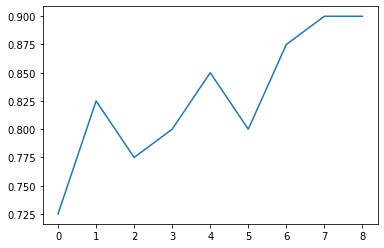

In [11]:
predicts_by_n = []
for number_of_images in range(1, 10):
    X_train = data[:, :number_of_images, :, :].reshape(40 * number_of_images, 112, 92)
    X_test = data[:, -1, :, :].reshape(40, 112, 92)
    y_train = np.array(target).reshape(40, -1)[:, :number_of_images].reshape(-1)
    y_test = np.array(target).reshape(40, -1)[:, -1].reshape(-1)
    model = KNeighborsClassifier(feature_to_use='dct', slice_dct=19)
    model.fit(X_train, y_train)
    predicts_by_n.append(accuracy_score(y_test, model.predict(X_test)))
    
plt.plot(predicts_by_n)

In [12]:
class VotingClassifier:
    def __init__(self, classifiers):
        self.classifiers = classifiers
        
    def fit(self, X, y):
        for c in self.classifiers:
            c.fit(X, y)
            
    def predict(self, X):
        answers_temp = []
        for c in self.classifiers:
            answers_temp.append(c.predict(X))
            
        answers_final = []
        for preds in zip(*answers_temp):
            answer = Counter(preds).most_common(1)[0][0]
            answers_final.append(answer)
        
        return answers_final

In [13]:
oof = np.zeros_like(y)
kfold_validation = StratifiedKFold(n_splits=5, shuffle=True)

for train_index, test_index in kfold_validation.split(X, y):
    voting_classifier = VotingClassifier(
        [
            KNeighborsClassifier(feature_to_use='dct', slice_dct=18, n_neighbors=1),
            KNeighborsClassifier(feature_to_use='fft', slice_dct=17, n_neighbors=1),
            KNeighborsClassifier(feature_to_use='hog', gradient_param=8, n_neighbors=1),
            KNeighborsClassifier(feature_to_use='scale', slice_dct=2, n_neighbors=2)
        ]
    )
    voting_classifier.fit(X[train_index], y[train_index])
    oof[test_index] = voting_classifier.predict(X[test_index])
print('accuracy is: ', accuracy_score(y, oof))

accuracy is:  0.9775
